In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import os
# Change the current working directory
os.chdir('/content/drive/My Drive/RHP_deeplearning')

In [3]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 33.5 MB/s eta 0:00:00


In [10]:
from tensorflow.python.ops.gen_array_ops import prevent_gradient
import numpy as np
import os
import gc
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate, Lambda
from tensorflow.keras import backend as K
from itertools import product
import h5py


# For GPU usage, set batch_size
batch_size = 2048
verification_file_route = 'verification/Mmus_features.hdf5'
model_route = 'PRI_prediction_V3_concat.h5'

# Define a translation dictionary
translation_dict = {
    "C": 1, "Y": 1, "A": 1, "T": 1, "G": 1,
    "S": 2, "Q": 2, "H": 2, "N": 2, "P": 2,
    "L": 3, "I": 3, "F": 3, "W": 3, "V": 3, "M": 3,
    "E": 4, "D": 4, "R": 4, "K": 4,
    "X": 5,  # Assign a special code for "X"
}

def translate_sequence(seq):
    # Translate the sequence
    num_list = [translation_dict.get(aa, 5) for aa in seq]

    # Convert the list to a string and remove unwanted characters
    num_str = str(num_list).replace("[", "").replace("]", "").replace(",", "").replace(" ", "")

    return num_str

# Features extraction functions
def calculate_amino_acid_proportion(sequence):
    sequence=str(sequence)
    total_length = len(sequence)
    proportion = [sequence.count(str(i)) / total_length for i in range(1, 6)]
    length=len(sequence)/1000
    return proportion,length

def get_all_n_mers(n):
    amino_acids = ['1', '2', '3', '4', '5']
    all_n_mers = [''.join(p) for p in product(amino_acids, repeat=n)]  # Use product to generate all possible N-Mers
    return all_n_mers

def calculate_frequencies(sequence, all_n_mers):
    sequence=str(sequence)
    # Count the number of occurrences of all n-mers in the sequence
    n_mer_counts = [sequence.count(mer) for mer in all_n_mers]
    # Convert to frequency
    total_n_mer_counts = sum(n_mer_counts)
    n_mer_frequencies = [count / total_n_mer_counts for count in n_mer_counts]
    return n_mer_frequencies

def calculate_nmer_position_percentage(sequence, n):
    sequence=str(sequence)
    n_mer_list = get_all_n_mers(n)
    counts_list = []

    def count_n_mers(sequence,mer,n):
        counts=[0]*20
        start = 0
        while start < len(sequence):
            start_index = sequence.find(mer, start) # Locate and record the position of the first letter of n-mer
            if start_index == -1:  # If the n-mer is not found, end the loop
                break
            end_index = start_index + len(mer) - 1  # Calculate the position of the last letter of n-mer
            start_position = start_index / len(sequence)
            end_position = end_index / len(sequence)
            if start_position >= 1:
                start_position = 0.99999
            if end_position >= 1:
                end_position = 0.99999
            start_percentage = int(20 * start_position)  # Calculate the percentage of these mer's first and last letters relative to the length of the sequence
            end_percentage = int(20 * end_position)
            if start_percentage == end_percentage:
                counts[start_percentage] += 1
            for i in range(start_percentage, end_percentage):
                counts[i] += 1
            start = start_index + 1  # Update the starting position to find the next subsequence in the next iteration

            # Do normalization if n=1
        if n == 1:
            total = sum(counts)
            if total != 0:
                counts = [10*(i/total) for i in counts]
        return counts

    # Create a list to store the counts for each n-mer
    for n_mer in n_mer_list:
        con = count_n_mers(sequence, n_mer, n)
        counts_list.append(con)

    return counts_list

def APAAC(sequence, maxlag):
    sequence = str(sequence)
    def calculate_h_values(sequence, H):
        sequence = list(map(int, str(sequence)))
        h_values = []
        hdiff_matrix = []
        for d in range(1, maxlag+1):
            hdiff_in_lengths = [0]*20
            sum_of_h = 0
            blur = 0
            item = 0
            # Calculate sum of H difference
            for i in range(len(sequence) - d):
                # If 5 is present in the sequence, blur the 5 related d value in sum
                if sequence[i] == 5 or sequence[i+d] == 5:
                    blur += 1
                    h_val = sum_of_h/item
                else:
                    h_val = H[sequence[i]-1] * H[sequence[i+d]-1]
                    item += 1
                    sum_of_h += h_val

            sum_of_h = blur*(sum_of_h/item) + sum_of_h
            ave_h = sum_of_h/(blur + item)

            # Calculate H difference in a length percentage list
            for k in range(len(sequence) - d):
                length_percentage = k / (len(sequence) - d)
                if length_percentage >= 1:
                    length_percentage = 0.99999
                if sequence[i] == 5 or sequence[i+d] == 5:
                    h_val = ave_h
                else:
                    h_val = H[sequence[i]-1] * H[sequence[i+d]-1]
                hdiff_in_lengths[int(20 * length_percentage)] += h_val

            h_values.append(sum_of_h / (len(sequence) - d))
            hdiff_in_lengths = [10*(block / (len(sequence) - d)) for block in hdiff_in_lengths]
            hdiff_matrix.append(hdiff_in_lengths)
        return h_values, hdiff_matrix

    # Calculate H1
    H1_value, H1_matrix = calculate_h_values(sequence, H1)
    H2_value, H2_matrix = calculate_h_values(sequence, H2)
    H1_features = [10*i for i in H1_value]
    H2_features = [10*i for i in H2_value]

    # Calculate features
    w = 0.1  # Weight
    denominator = sum(H1_value + H2_value) * w + 1  # Constant denominator

    # Calculate APAAC descriptor
    apaac1 = [100 * w * h_value / denominator for h_value in H1_value]
    apaac2 = [100 * w * h_value / denominator for h_value in H2_value]

    return H1_features, H1_matrix, H2_features, H2_matrix, apaac1, apaac2

# Define Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def get_positional_encoding(seq_length, d_model):
    # Initialize a matrix of zeros with shape (seq_length, d_model)
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_length, d_model))
    # Apply the positional encoding formula
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    pos_enc = pos_enc[np.newaxis, ...]
    return tf.cast(pos_enc, dtype=tf.float32)

def add_positional_encoding(inputs):
    _, seq_length, d_model = inputs.shape.as_list()
    pos_enc = get_positional_encoding(seq_length, d_model)
    return inputs + pos_enc

def process_posA(input_A):
    out_A = layers.Flatten()(input_A)
    out_A = Dense(4300, activation='relu')(out_A)
    out_A = Dense(4096, activation='relu')(out_A)
    out_A = Dense(2048, activation='relu')(out_A)
    out_A = Dense(1024, activation='relu')(out_A)
    out_A = Dense(512, activation='relu')(out_A)
    out_A = Dense(256, activation='relu')(out_A)
    return out_A

def process_posB(input_B):
    out_B = layers.Flatten()(input_B)
    out_B = Dense(4300, activation='relu')(out_B)
    out_B = Dense(4096, activation='relu')(out_B)
    out_B = Dense(2048, activation='relu')(out_B)
    out_B = Dense(1024, activation='relu')(out_B)
    out_B = Dense(512, activation='relu')(out_B)
    out_B = Dense(256, activation='relu')(out_B)
    return out_B

def process_sumA(input_A):
    out_A = Dense(126, activation='relu')(input_A)
    out_A = Dense(96, activation='relu')(out_A)
    out_A = Dense(64, activation='relu')(out_A)
    return out_A

def process_sumB(input_B):
    out_B = Dense(126, activation='relu')(input_B)
    out_B = Dense(96, activation='relu')(out_B)
    out_B = Dense(64, activation='relu')(out_B)
    return out_B

def stack_tensors(tensors):
    return K.stack(tensors, axis=1)

def create_model(input_shape_posA, input_shape_posB, input_shape_sumA, input_shape_sumB):
    # Define the input layers
    input_posA = Input(shape=input_shape_posA)
    input_posB = Input(shape=input_shape_posB)
    input_sumA = Input(shape=input_shape_sumA)
    input_sumB = Input(shape=input_shape_sumB)

    # Process inputs
    out_posA = process_posA(input_posA)
    out_posB = process_posB(input_posB)
    out_sumA = process_sumA(input_sumA)
    out_sumB = process_sumB(input_sumB)

    # Combine posA with sumA and posB with sumB
    outA = layers.Concatenate(axis=-1)([out_posA, out_sumA])
    outB = layers.Concatenate(axis=-1)([out_posB, out_sumB])

    stacked = Lambda(stack_tensors)([outA, outB])
    pos_stacked = Lambda(add_positional_encoding)(stacked)
    transformer_block1 = TransformerBlock(embed_dim=320, num_heads=8, ff_dim=64)
    out = transformer_block1(pos_stacked)
    out = Flatten()(out)

    # Further processing
    out = Dense(640, activation='relu')(out)
    out = Dense(320, activation='relu')(out)
    out = Dropout(0.1)(out)
    out = Dense(128, activation='relu')(out)
    out = Dropout(0.2)(out)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.3)(out)
    out = Dense(1, activation='sigmoid')(out)

    # Compile model
    model = Model(inputs=[input_posA, input_posB, input_sumA, input_sumB], outputs=out)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hydrophobicity list H1 (by LogP)
H1 = np.array([-0.512233954, -0.38383707, 1.710733781, -0.814662758])

# Hydrophilicity list H2 (by polar surface area)
H2 = np.array([-0.959054378, 1.359590767, -0.959054378, 0.558517989])

# Load the model
model = load_model(
    model_route,
    custom_objects={
    'TransformerBlock': TransformerBlock,
    'stack_tensors': stack_tensors,
    'add_positional_encoding': add_positional_encoding,
    'get_positional_encoding': get_positional_encoding
    }
)

# Initializes an empty DataFrame to store all predictions
all_predictions = pd.DataFrame()

# Open the HDF5 file
with h5py.File(verification_file_route, 'r') as f:
    # Read datasets
#    interactions = f['interaction'][:]
#    proteinA = f['proteinA'][:]
#    proteinB = f['proteinB'][:]

    one_mer_countsA = f['one_mer_countsA'][:]
    two_mer_countsA = f['two_mer_countsA'][:]
    three_mer_countsA = f['three_mer_countsA'][:]
    one_mer_countsB = f['one_mer_countsB'][:]
    two_mer_countsB = f['two_mer_countsB'][:]
    three_mer_countsB = f['three_mer_countsB'][:]

    proportion_A = f['proportion_A'][:]
    length_A = f['length_A'][:]

    H1_featuresA = f['H1_featuresA'][:]
    H2_featuresA = f['H2_featuresA'][:]
    H1_matrixA = f['H1_matrixA'][:]
    H2_matrixA = f['H2_matrixA'][:]
    apaac1A = f['apaac1A'][:]
    apaac2A = f['apaac2A'][:]

    proportion_B = f['proportion_B'][:]
    length_B = f['length_B'][:]

    H1_featuresB = f['H1_featuresB'][:]
    H2_featuresB = f['H2_featuresB'][:]
    H1_matrixB = f['H1_matrixB'][:]
    H2_matrixB = f['H2_matrixB'][:]
    apaac1B = f['apaac1B'][:]
    apaac2B = f['apaac2B'][:]

    # Merge A and B positional properties to an array
    posA = np.concatenate((one_mer_countsA, two_mer_countsA, three_mer_countsA, H1_matrixA, H2_matrixA), axis=1)
    posB = np.concatenate((one_mer_countsB, two_mer_countsB, three_mer_countsB, H1_matrixB, H2_matrixB), axis=1)
    sumA = np.concatenate((H1_featuresA, H2_featuresA, apaac1A, apaac2A), axis=1)
    sumB = np.concatenate((H1_featuresB, H2_featuresB, apaac1B, apaac2B), axis=1)
    length_A_2d = length_A[:, np.newaxis]
    length_B_2d = length_B[:, np.newaxis]
    sumA = np.concatenate((sumA,proportion_A,length_A_2d),axis=1)
    sumB = np.concatenate((sumB,proportion_B,length_B_2d),axis=1)

# 计算总共需要迭代的次数
total_samples = len(posA)
total_batches = (total_samples + batch_size - 1) // batch_size

# 初始化结果列表
predictions = []

# 使用tqdm创建进度条，并迭代处理每个批次的数据
for batch_idx in tqdm(range(total_batches)):
    # 计算当前批次的起始索引和结束索引
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, total_samples)

    # 提取当前批次的数据
    batch_pos_featuresA = posA[start_idx:end_idx]
    batch_sum_featuresA = sumA[start_idx:end_idx]
    batch_pos_featuresB = posB[start_idx:end_idx]
    batch_sum_featuresB = sumB[start_idx:end_idx]

    # 使用模型进行预测
    batch_predictions = model.predict([batch_pos_featuresA, batch_pos_featuresB, batch_sum_featuresA, batch_sum_featuresB], verbose=0)

    # 将批次的预测结果添加到总体结果列表中
    predictions.extend(batch_predictions)

print("Prediction complete. The prediction.csv has been generated. Press any key to exit...")

interactions = np.ones_like(length_B)
aim_interaction = interactions
aim_prediction = np.ravel(predictions)

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

Prediction complete. The prediction.csv has been generated. Press any key to exit...


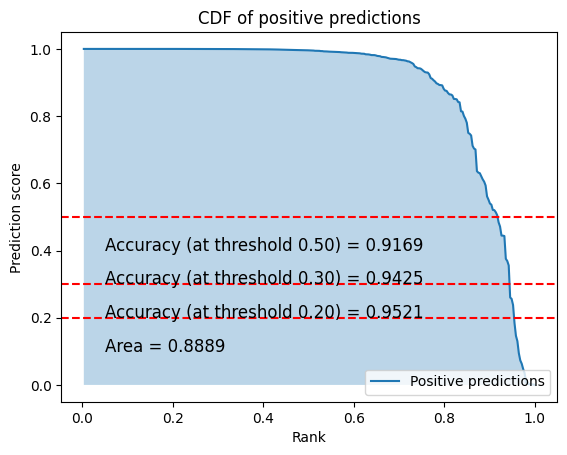

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 定义一个计算准确率的函数
def calculate_accuracy(predictions, threshold):
    # 根据阈值将预测值转化为类别
    predicted_classes = [1 if pred >= threshold else 0 for pred in predictions]
    # 计算准确率（所有预测为1的样本都是真正的正样本）
    accuracy = sum(predicted_classes) / len(predicted_classes)
    return accuracy

# 根据 aim_interaction 中的值是1的位置，来抽取 aim_prediction 中对应位置的值
prediction_positive = [pred for inter, pred in zip(aim_interaction, aim_prediction) if inter == 1]

# 对 prediction_positive 进行从高到低的排序
prediction_positive.sort()

# 生成对应的x值，从1/N递减到0
x_values = np.linspace(1, 1/len(prediction_positive), len(prediction_positive))

# 计算面积（实际上是预测分数的平均值）
area = np.mean(prediction_positive)

# 设定阈值
threshold1 = 0.2
accuracy1 = calculate_accuracy(prediction_positive, threshold1)
threshold2 = 0.3
accuracy2 = calculate_accuracy(prediction_positive, threshold2)
threshold3 = 0.5
accuracy3 = calculate_accuracy(prediction_positive, threshold3)

# 画出折线图并在折线下方进行染色
plt.figure()
plt.plot(x_values, prediction_positive, label='Positive predictions')
plt.fill_between(x_values, 0, prediction_positive, alpha=0.3)
plt.axhline(y=threshold1, color='r', linestyle='--')  # 画出阈值线
plt.axhline(y=threshold2, color='r', linestyle='--')  # 画出阈值线
plt.axhline(y=threshold3, color='r', linestyle='--')  # 画出阈值线
plt.xlabel('Rank')
plt.ylabel('Prediction score')
plt.title('CDF of positive predictions')
plt.legend(loc="lower right")

# 在图上显示面积和准确率
plt.text(0.05, 0.1, 'Area = {:.4f}'.format(area), fontsize=12)
plt.text(0.05, 0.2, 'Accuracy (at threshold {:.2f}) = {:.4f}'.format(threshold1, accuracy1), fontsize=12)
plt.text(0.05, 0.3, 'Accuracy (at threshold {:.2f}) = {:.4f}'.format(threshold2, accuracy2), fontsize=12)
plt.text(0.05, 0.4, 'Accuracy (at threshold {:.2f}) = {:.4f}'.format(threshold3, accuracy3), fontsize=12)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 根据 aim_interaction 中的值是1的位置，来抽取 aim_prediction 中对应位置的值
prediction_positive = [pred for inter, pred in zip(aim_interaction, aim_prediction) if inter == 0]

# 对 prediction_positive 进行从高到低的排序
prediction_positive.sort()

# 生成对应的x值，从1/N递减到0
x_values = np.linspace(1, 1/len(prediction_positive), len(prediction_positive))

# 计算面积（实际上是预测分数的平均值）
area = np.mean(prediction_positive)

# 画出折线图并在折线下方进行染色
plt.figure()
plt.plot(x_values, prediction_positive, label='Negative predictions')
plt.fill_between(x_values, 0, prediction_positive, alpha=0.3)
plt.xlabel('Rank')
plt.ylabel('Prediction score')
plt.title('CDF of negative predictions')
plt.legend(loc="lower right")

# 在图上显示面积
plt.text(0.7, 0.9, 'Area = {:.4f}'.format(area), fontsize=12)

plt.show()

ZeroDivisionError: ignored